<a href="https://colab.research.google.com/github/cwirex/NeuralNetworks/blob/main/gann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANN: Heart Diseases
Example of genetic algorithm combined with training neural networks.

## Imports

In [275]:
!pip install pygad
import pygad
import pygad.nn
import pygad.gann
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Prepare data

In [276]:
df = pd.read_csv("sample_data/heart-disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [277]:
# Get X and y
y = df.target.values
dfX = df.loc[:, df.columns != "target"]
dfX = (dfX-dfX.min())/(dfX.max()-dfX.min())   # normalize data
X = dfX.values

print(f"X.shape={X.shape},  y.shape={y.shape}")
assert X.shape[0] == y.shape[0]

X.shape=(303, 13),  y.shape=(303,)


In [278]:
# Split to train and test datasets
test_size=0.15
X, X_test, y, y_test = train_test_split(X, y, test_size=test_size, random_state=123)
print(f"X.shape={X.shape},  y.shape={y.shape}")
print(f"X_test.shape={X_test.shape},  y_test.shape={y_test.shape}")

X.shape=(257, 13),  y.shape=(257,)
X_test.shape=(46, 13),  y_test.shape=(46,)


## Model I

In [279]:
# define parameters
n_params = X.shape[1]             # number of inputs
n_classes = 2                     # number of output neurons
num_solutions = 10                # number of neural networks in each generation 
num_parents_mating = 3            # number of solutions to be selected as parents in the mating pool.
num_generations = 500             # total number of generations
mutation_percent_genes = 10       # percentage of genes to mutate.
parent_selection_type = "tournament"
crossover_type = "single_point"
mutation_type = "random"
keep_parents = -1                 # Keep all parents in the next generation.
init_range_low = -4
init_range_high = 4

In [280]:
# Define gann functions
def fitness_func(solution, sol_idx):
    global GANN_instance

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=X)
    correct_predictions = np.where(predictions == y)[0].size
    solution_fitness = (correct_predictions/y.size)

    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks,
                                                            population_vectors=ga_instance.population)
    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print(f"Generation = {ga_instance.generations_completed} : fit = {ga_instance.best_solution()[1]:.4f}, change = {ga_instance.best_solution()[1] - last_fitness:.4f}")
    last_fitness = ga_instance.best_solution()[1].copy()

In [281]:
last_fitness = 0
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=n_params,       # 13 input neurons
                                num_neurons_hidden_layers=[10],   # one hidden layer with 10 neurons
                                num_neurons_output=n_classes,     # 2 output neurons (representing classes)
                                hidden_activations=["relu"],
                                output_activation="softmax")

population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)
initial_population = population_vectors.copy()

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation
                       )

In [282]:
ga_instance.run()

Generation = 1 : fit = 0.5642, change = 0.5642
Generation = 2 : fit = 0.5370, change = -0.0272
Generation = 3 : fit = 0.5331, change = -0.0039
Generation = 4 : fit = 0.5875, change = 0.0545
Generation = 5 : fit = 0.6226, change = 0.0350
Generation = 6 : fit = 0.5953, change = -0.0272
Generation = 7 : fit = 0.6576, change = 0.0623
Generation = 8 : fit = 0.6148, change = -0.0428
Generation = 9 : fit = 0.6226, change = 0.0078
Generation = 10 : fit = 0.6848, change = 0.0623
Generation = 11 : fit = 0.5914, change = -0.0934
Generation = 12 : fit = 0.6070, change = 0.0156
Generation = 13 : fit = 0.5837, change = -0.0233
Generation = 14 : fit = 0.6654, change = 0.0817
Generation = 15 : fit = 0.6148, change = -0.0506
Generation = 16 : fit = 0.6459, change = 0.0311
Generation = 17 : fit = 0.7043, change = 0.0584
Generation = 18 : fit = 0.5720, change = -0.1323
Generation = 19 : fit = 0.6809, change = 0.1089
Generation = 20 : fit = 0.7004, change = 0.0195
Generation = 21 : fit = 0.6848, change = 

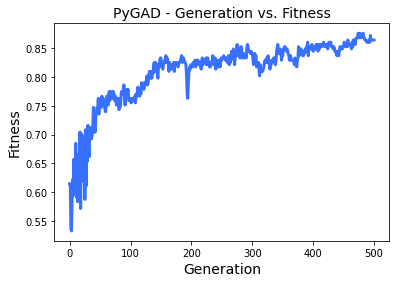

Fitness value of the best solution = 0.86381
Best fitness value reached after 474 generations
Number of correct classifications: 38 (82.6%)
Number of wrong classifications: 8 (17.4%)


In [283]:
# Summary
ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness:.5f}")

if ga_instance.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance.best_solution_generation} generations")

# Predicting the outputs of the TRAINING data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                               data_inputs=X_test)

# Calculating some statistics
num_total = y_test.size
num_wrong = np.where(predictions != y_test)[0].size
num_correct = num_total - num_wrong
accuracy = 100 * (num_correct/num_total)
print(f"Number of correct classifications: {num_correct} ({100.*num_correct/num_total:.1f}%)")
print(f"Number of wrong classifications: {num_wrong} ({100.*num_wrong/num_total:.1f}%)")

## Model II

In [301]:
# Redefine parameters       
num_solutions = 20                    # 10 -> 20     
num_generations = 300                 # 500 -> 300      
num_parents_mating = num_solutions//2 # 3 -> 1/2 of total solutions
mutation_percent_genes = 5            # 10 -> 5
parent_selection_type = "sss"         # tournament -> sss
crossover_type = "two_points"         # single_point -> two_points
keep_parents = num_parents_mating//2  # all -> 1/2 of total parents
init_range_low = 0                    # 
init_range_high = 1                   # 

In [302]:
# Define gann functions
def fitness_func2(solution, sol_idx):
    global GANN_instance2, X, y

    predictions = pygad.nn.predict(last_layer=GANN_instance2.population_networks[sol_idx],
                                   data_inputs=X)
    correct_predictions = np.where(predictions == y)[0].size
    solution_fitness = (correct_predictions/y.size)

    return solution_fitness

def callback_generation2(ga_instance):
    global GANN_instance2, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance2.population_networks,
                                                            population_vectors=ga_instance.population)
    GANN_instance2.update_population_trained_weights(population_trained_weights=population_matrices)
    change = ga_instance.best_solution()[1] - last_fitness
    if change != 0 or ga_instance.generations_completed == 1:
      print(f"\nGeneration = {ga_instance.generations_completed} : fit = {ga_instance.best_solution()[1]:.4f}, change = {change:.4} ", end='')
    else:
      print(".", end='')
    last_fitness = ga_instance.best_solution()[1].copy()

In [303]:
GANN_instance2 = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=n_params,
                                num_neurons_hidden_layers=[30],
                                num_neurons_output=n_classes,
                                hidden_activations=["relu"],
                                output_activation="softmax")

population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance2.population_networks)
initial_population = population_vectors.copy()

ga_instance2 = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func2,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation2)
                      #  K_tournament=K_tournament)
last_fitness = 0
ga_instance2.run()


Generation = 1 : fit = 0.7276, change = 0.7276 
Generation = 2 : fit = 0.7626, change = 0.03502 
Generation = 3 : fit = 0.8210, change = 0.05837 ..........
Generation = 14 : fit = 0.8249, change = 0.003891 .............
Generation = 28 : fit = 0.8327, change = 0.007782 ..
Generation = 31 : fit = 0.8366, change = 0.003891 ...
Generation = 35 : fit = 0.8405, change = 0.003891 ......
Generation = 42 : fit = 0.8444, change = 0.003891 ..
Generation = 45 : fit = 0.8482, change = 0.003891 .
Generation = 47 : fit = 0.8521, change = 0.003891 .......
Generation = 55 : fit = 0.8599, change = 0.007782 ............
Generation = 68 : fit = 0.8638, change = 0.003891 ....................
Generation = 89 : fit = 0.8677, change = 0.003891 ......................................
Generation = 128 : fit = 0.8716, change = 0.003891 .......
Generation = 136 : fit = 0.8755, change = 0.003891 .....................................................................................................................
G

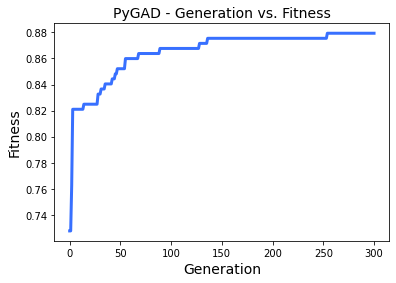

Fitness value of the best solution = 0.87938
Best fitness value reached after 254 generations
Number of correct classifications: 39 (84.8%)
Number of wrong classifications: 7 (15.2%)


In [304]:
# Summary
ga_instance2.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance2.best_solution()
print(f"Fitness value of the best solution = {solution_fitness:.5f}")

if ga_instance2.best_solution_generation != -1:
    print(f"Best fitness value reached after {ga_instance2.best_solution_generation} generations")

# Predicting the outputs of the TRAINING data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance2.population_networks[solution_idx],
                               data_inputs=X_test)

# Calculating some statistics
num_total = y_test.size
num_wrong = np.where(predictions != y_test)[0].size
num_correct = num_total - num_wrong
accuracy = 100 * (num_correct/num_total)
print(f"Number of correct classifications: {num_correct} ({100.*num_correct/num_total:.1f}%)")
print(f"Number of wrong classifications: {num_wrong} ({100.*num_wrong/num_total:.1f}%)")

*Author: Mateusz Oćwieja*